# Compatibility betwene (Post-processing) Wasserstein Pareto Frontier and Individual Fairness Experiment on CRIME Data Set

## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://archive.ics.uci.edu/ml/datasets/communities+and+crime

In [1]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from scipy.io import loadmat
from time import perf_counter
from tabulate import tabulate

# import data
path =r'/Users/shizhouxu/Documents/LIBRARY/Python/Fair_L2_Supervised_Learning/Communities-Crime/' # use your path
attrib = pd.read_csv(path + 'attributes.csv', delim_whitespace = True)
data = pd.read_csv(path + 'communities.data', names = attrib['attributes'])
data = data.drop(columns=['state','county','community','communityname','fold'], axis=1)
data = data.replace('?', np.nan)
feat_miss = data.columns[data.isnull().any()]
# clearning up the "Nan" in data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(data[['OtherPerCap']])
data[['OtherPerCap']] = imputer.transform(data[['OtherPerCap']])
data = data.dropna(axis=1)
# following "Fair Regression with Wasserstein Barycenters", we made the sensitive variable (race) binary for comparison purpose
# binary variable that indicating dominance of black race population in the community: brate_binary
brate = data['racepctblack']
np.unique(brate)
brate_binary = np.zeros(len(brate))

for i in range(0,len(brate)):
    brate_binary[i] = (brate[i] >= 0.3)*1
    
# independnet variable without race features (which are linearly dependnet of brate_binary): X_d
X_d = np.array(data.drop(['racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'ViolentCrimesPerPop'],axis = 1))
# independnet variable that is a direct sum of X_d and brate_binary: X
X = np.concatenate((X_d,brate_binary[...,np.newaxis]),axis = 1)
# dependnet variable: Y
Y = np.array(data[['ViolentCrimesPerPop']])
# sensitive variable: Z
Z = X[:,96]

# five-fold cross validation data sets
trainX_list = []
trainX_d_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testX_d_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.5, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,96] == 1)*1)
    testZ_list.append((testX[:,96] == 1)*1)

for i in range(0,5):
    trainX_d, testX_d, trainY, testY = train_test_split(X_d, Y, test_size=0.5, random_state=i)
    trainX_d_list.append(trainX_d)
    testX_d_list.append(testX_d)

## MSE and W2 of Linear Regression
1. original data + McCann interpolation
2. original data deleting the sensitive variable

### 1. original data + McCann interpolation

In [2]:
# 1. MSE and W2 of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
W2_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)
    
# L2 resulting from original data: L2_origin
L2_origin_list = np.sqrt(MSE_origin_list)
    
# W2 resulting from original data: W2_origin
for i in range(0,len(trainX_list)):
    W2_origin = ot.emd2_1d(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    W2_origin_list.append(np.sqrt(W2_origin))

In [12]:
# 2. MSE and KS of linear regression + Post-processing Wasserstein geodesic path to pseudo-barycenter

T = np.linspace(0,1,50) # discretize time variable T
P_train_path_list = [] # prediction on train data set
P_test_path_list = [] # prediction on test data set
time_origin_list = [] # time recording
L_list = []

for i in range(0,len(trainX_list)):
    t = perf_counter()
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Generate prediction P
    P = model_origin.predict(trainX_list[i])
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    A_sup = max(abs((P_A[:,0] - P_A_mean)))
    C_sup = max(abs((P_C[:,0] - P_C_mean)))

    L_list.append(abs((P_A_mean - P_C_mean)) + max(abs(T_P_A), abs(T_P_C))*max(A_sup, C_sup))
    
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    for t in range(0,len(T)):
        P_t = model_origin.predict(testX_list[i])
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = ((1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean))[:,0]
        temp[testZ_list[i] == 1] = ((1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean))[:,0]
        P_test_path.append(temp)
    P_test_path_list.append(P_test_path)
    time_origin_list.append(perf_counter() - t)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_LR = []
P_MSE_fair_LR = []
# W2 at the pseudo-barycenter
P_W2_origin_LR = []
P_W2_fair_LR = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list = []
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list
P_W2_path_list = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_MSE_origin_LR.append(((testY_list[i] - P_test_path_list[i][0])**2).mean(axis = 0))
    P_W2_path = []
    P_W2_origin_LR.append(np.sqrt(ot.emd2_1d(P_test_path_list[i][0][testZ_list[i] == 0], P_test_path_list[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - P_test_path_list[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        P_MSE_path.append(MSE_fair)
        W2_fair = np.sqrt(ot.emd2_1d(P_test_path_list[i][t][testZ_list[i] == 0], P_test_path_list[i][t][testZ_list[i] == 1]))
        P_W2_path.append(W2_fair)
    P_MSE_fair_LR.append(MSE_fair)
    P_MSE_path_list.append(P_MSE_path)
    P_W2_fair_LR.append(W2_fair)
    P_W2_path_list.append(P_W2_path)

P_L2_origin_LR = np.sqrt(P_MSE_origin_LR)
P_L2_fair_LR = np.sqrt(P_MSE_fair_LR)   

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_LR = np.average(np.array(P_MSE_path_list),axis = 0)
# mean of W2s from the five test sets: MSE_LR, KS_LR
P_L2_LR = np.average(np.sqrt(np.array(P_MSE_path_list)),axis = 0)
P_W2_LR = np.average(np.array(P_W2_path_list),axis = 0)

In [15]:
# Now, we compute the minimum energy level: V

V_list = []

for i in range(0,len(trainX_list)):
    P = Y_hat_list_t[i][:,0]
    P_fair = P_test_path_list[i][49]
    V_list.append(np.sqrt(((P - P_fair)**2).mean(axis = 0)))
    
V = max(V_list)

# Next, find the operator norm of the transport maps we use to find K

L = max(L_list)

"""
Therefore, if the difference between delta and epsilon in the individual fairness is K,
then the W2 disparity tolerance d needs to be more than V/sqrt(2) for the Pareto frontier to be compatible.
In other words, the last 1-V/sqrt(2)/sqrt(2)V = 0.5 portion of Pareto frontier is compatible.

If the difference is K/2,
then d needs to be more than 3/4,
the last 1-3/4 = 1/4 portion of the Pareto frontier is compatible.
"""

'\nTherefore, if the difference between delta and epsilon in the individual fairness is K,\nthen the W2 disparity tolerance d needs to be more than V/sqrt(2) for the Pareto frontier to be compatible.\nIn other words, the last 1-V/sqrt(2)/sqrt(2)V = 0.5 portion of Pareto frontier is compatible.\n\nIf the difference is K/2,\nthen d needs to be more than 3/4,\nthe last 1-3/4 = 1/4 portion of the Pareto frontier is compatible.\n'

### 2. original data w/o sensitive variable

In [17]:
# 3. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
W2_d_list = []
                        
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)[0]
    MSE_d_list.append(MSE_d)

L2_d_list = np.sqrt(MSE_d_list)

# W2 resulting from data w/o sensitive variable: W2_d
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    W2_d_list.append(np.sqrt(W2_d))

## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data + McCann interpolation
3. original data deleting the sensitive variable

In [19]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1 & 2. MSE and KS of ANN + post-processing on the original data

In [ ]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t_ANN = [] # prediction on test data set
Y_hat_list_l_ANN = [] # prediction on train data set
time_origin_list_ANN = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    X_train = sc.fit_transform(trainX_list[i])
    X_test = sc.transform(testX_list[i])
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[i,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(trainX_list[i], trainY_list[i], batch_size = 10, epochs = 100)
    Y_hat_t_ANN = model.predict(testX_list[i])
    Y_hat_l_ANN = model.predict(trainX_list[i])
    # Test on the marginal test data for discrimination
    Y_hat_list_t_ANN.append(Y_hat_t_ANN)
    Y_hat_list_l_ANN.append(Y_hat_l_ANN)
    time_origin_list_ANN.append(perf_counter() - t)
    
MSE_origin_list_ANN = []
W2_origin_list_ANN = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t_ANN[i])**2).mean(axis = 0)
    MSE_origin_list_ANN.append(MSE_origin)
    
# L2 resulting from original data: L2_origin
L2_origin_list_ANN = np.sqrt(MSE_origin_list_ANN)
    
# W2 resulting from original data: W2_origin
for i in range(0,len(trainX_list)):
    W2_origin = ot.emd2_1d(Y_hat_list_t_ANN[i][testZ_list[i] == 0], Y_hat_list_t_ANN[i][testZ_list[i] == 1])
    W2_origin_list_ANN.append(np.sqrt(W2_origin))
    
    

In [22]:
# 2. MSE and KS of ANN + Post-processing Wasserstein geodesic path to pseudo-barycenter


P_train_path_list_ANN = [] # prediction on train data set
P_test_path_list_ANN = [] # prediction on test data set
time_origin_list_ANN = [] # time recording
L_list_ANN = []

for i in range(0,len(trainX_list)):
    
    t = perf_counter()
    # Generate prediction P on the training data
    P = Y_hat_list_l_ANN[i]
    # mean and covariance of P
    P_mean = np.mean(P)
    P_cov = np.cov(P.T)
    # marginal/conditional variable, mean, and covariance of P
    P_A = P[trainZ_list[i] == 0]
    P_C = P[trainZ_list[i] == 1]
    P_A_mean = np.average(P_A)
    P_C_mean = np.average(P_C)
    P_A_cov = np.cov(P_A.T)
    P_C_cov = np.cov(P_C.T)
    # algorithm 2, step 1: iterative process to the barycenter covariance matrix with stop cirterion error equals 0.0000000000001
    P_bar = np.random.rand() 
    eps = 10
    while eps > 0.0000000000000000000001:
        P_new = ((len(P_A)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_A_cov*np.sqrt(P_bar))) + ((len(P_C)/len(P)) * np.sqrt(np.sqrt(P_bar)*P_C_cov*np.sqrt(P_bar)))
        eps = P_bar - P_new
        P_bar = P_new
    # algorithm 2, step 2: the corresponding Brenier's map for marginals f(X_z)
    T_P_A = (1/np.sqrt(P_A_cov)) * np.sqrt( np.sqrt(P_A_cov) * P_bar * np.sqrt(P_A_cov) ) * (1/np.sqrt(P_A_cov))
    T_P_C = (1/np.sqrt(P_C_cov)) * np.sqrt( np.sqrt(P_C_cov) * P_bar * np.sqrt(P_C_cov) ) * (1/np.sqrt(P_C_cov))
    
    A_sup = max(abs((P_A[:,0] - P_A_mean)))
    C_sup = max(abs((P_C[:,0] - P_C_mean)))
    L_list_ANN.append(abs((P_A_mean - P_C_mean)) + max(abs(T_P_A), abs(T_P_C))*max(A_sup, C_sup))
    
    # algorithm 2, step 3: generate the geodesic path to the pseudo-barycenter
    P_train_path = []
    P_test_path = []
    P_t = Y_hat_list_t_ANN[i][:,0]
    for t in range(0,len(T)):
        temp = np.random.rand(len(P_t))
        temp[testZ_list[i] == 0] = (1 - T[t] + T[t]*T_P_A)*P_t[testZ_list[i] == 0] + T[t]*(P_mean - T_P_A*P_A_mean)
        temp[testZ_list[i] == 1] = (1 - T[t] + T[t]*T_P_C)*P_t[testZ_list[i] == 1] + T[t]*(P_mean - T_P_C*P_C_mean)
        P_test_path.append(temp)
    P_test_path_list_ANN.append(P_test_path)
    time_origin_list_ANN.append(perf_counter() - t)
    
# MSE and KS at the pseudo-barycenter
P_MSE_origin_ANN = []
P_MSE_fair_ANN = []
# MSE and KS at the pseudo-barycenter
P_W2_origin_ANN = []
P_W2_fair_ANN = []    
    
# MSE of predictions from model trained via the post-processing interpolation: P_MSE_path_list
P_MSE_path_list_ANN = []
# W2 of predictions from model trained via the post-processing interpolation: P_W2_path_list_ANN
P_W2_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    P_MSE_path = []
    P_MSE_origin_ANN.append(((testY_list[i][:,0] - P_test_path_list_ANN[i][0])**2).mean(axis = 0))
    P_W2_path = []
    P_W2_origin_ANN.append(np.sqrt(ot.emd2_1d(P_test_path_list_ANN[i][0][testZ_list[i] == 0], P_test_path_list_ANN[i][0][testZ_list[i] == 1])))
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i][:,0] - P_test_path_list_ANN[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        P_MSE_path.append(MSE_fair)
        W2_fair = ot.emd2_1d(P_test_path_list_ANN[i][t][testZ_list[i] == 0], P_test_path_list_ANN[i][t][testZ_list[i] == 1])
        P_W2_path.append(np.sqrt(W2_fair))
    P_MSE_fair_ANN.append(MSE_fair)
    P_MSE_path_list_ANN.append(P_MSE_path)
    P_W2_fair_ANN.append(np.sqrt(W2_fair))
    P_W2_path_list_ANN.append(P_W2_path)

P_L2_origin_ANN = np.sqrt(P_MSE_origin_ANN)
P_L2_fair_ANN = np.sqrt(P_MSE_fair_ANN)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
P_MSE_ANN = np.average(np.array(P_MSE_path_list_ANN),axis = 0)
# mean of W2s from the five test sets: W2_ANN
P_L2_ANN = np.average(np.sqrt(np.array(P_MSE_path_list_ANN)),axis = 0)
P_W2_ANN = np.average(np.array(P_W2_path_list_ANN),axis = 0)


In [25]:
# Now, we compute the minimum energy level: V

V_list_ANN = []

for i in range(0,len(trainX_list)):
    P = Y_hat_list_t_ANN[i][:,0]
    P_fair = P_test_path_list_ANN[i][49]
    V_list_ANN.append(np.sqrt(((P - P_fair)**2).mean(axis = 0)))
    
V_ANN = max(V_list_ANN)

# Next, find the operator norm of the transport maps we use to find K

L_ANN = max(L_list_ANN)

"""
Therefore, if the difference between delta and epsilon in the individual fairness is K,
then the W2 disparity tolerance d needs to be more than V/sqrt(2) for the Pareto frontier to be compatible.
In other words, the last 1-V/sqrt(2)/sqrt(2)V = 0.5 portion of Pareto frontier is compatible.

If the difference is K/2,
then d needs to be more than 3/4,
the last 1-3/4 = 1/4 portion of the Pareto frontier is compatible.
"""

'\nTherefore, if the difference between delta and epsilon in the individual fairness is K,\nthen the W2 disparity tolerance d needs to be more than V/sqrt(2) for the Pareto frontier to be compatible.\nIn other words, the last 1-V/sqrt(2)/sqrt(2)V = 0.5 portion of Pareto frontier is compatible.\n\nIf the difference is K/2,\nthen d needs to be more than 3/4,\nthe last 1-3/4 = 1/4 portion of the Pareto frontier is compatible.\n'

In [31]:
np.sqrt(V_ANN), L_ANN

(0.38945460300765894, 1.3846608912181968)

### 3. MSE and KS of ANN on the data tha deletes the sensitive variable

In [ ]:
Y_hat_d_list_t_ANN = [] # prediction on the test data set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

t = perf_counter()

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(trainX_d_list[i][0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter()-t)
    
MSE_d_list_ANN = [] #MSE
W2_d_list_ANN = [] #W2

# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i][:,0] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)
    
L2_d_list_ANN = np.sqrt(MSE_d_list_ANN)

# W2
for i in range(0,len(trainX_list)):
    W2_d = ot.emd2_1d(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    W2_d_list_ANN.append(np.sqrt(W2_d))

In [ ]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR, P_L2_LR, kind = "linear")

P_X_LR_W2=np.linspace(P_W2_LR.min(), P_W2_LR.max(), 500)
P_Y_LR_W2=interploation_model(P_X_LR_W2)
 
plt.plot(P_X_LR_W2, P_Y_LR_W2)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN, P_L2_ANN, kind = "linear")
 
P_X_ANN_W2=np.linspace(P_W2_ANN.min(), P_W2_ANN.max(), 500)
P_Y_ANN_W2=interploation_model(P_X_ANN_W2)
 
plt.plot(P_X_ANN_W2, P_Y_ANN_W2)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [34]:
# function that finds the barycenter by matching the cumulative distribution functions of two marginal/conditional random variables
def f_NIPS(Y_l, Y_t, Z_l, Z_t):
    u = np.unique(Z_l)
    nM = max([sum(Z_l==u[0]),sum(Z_l==u[1])])
    iM = np.argmax([sum(Z_l==u[0]),sum(Z_l==u[1])])
    nm = min([sum(Z_l==u[0]),sum(Z_l==u[1])])
    im = np.argmin([sum(Z_l==u[0]),sum(Z_l==u[1])])
    p = nm/len(Z_l)
    q = 1-p
    YF = np.zeros(len(Y_t))
    for i in range(0,len(Y_t)):
        print(i)
        if Z_t[i] == u[im]:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[iM]] < t)/nM
                tmp2 = sum(Y_l[Z_l==u[im]] < Y_t[i])/nm
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = p*Y_t[i]+q*ts
        else:
            dist_best = math.inf
            for t in np.linspace(min(Y_l),max(Y_l),100):
                tmp1 = sum(Y_l[Z_l==u[im]] < t)/nm
                tmp2 = sum(Y_l[Z_l==u[iM]] < Y_t[i])/nM
                dist = np.abs(tmp1-tmp2)
                if dist_best > dist:
                    dist_best = dist
                    ts = t
            YF[i] = q*Y_t[i]+p*ts
    return YF

In [ ]:
# train and test sensitive variable and prediction: Z_l(t), Y_l(t)
Z_l = trainZ_list # for CRIME data, use trainZ_list[i] = trainX_list[i][:,96]
Z_t = testZ_list # for CRIME data, use testZ_list[i] = testX_list[i][:,96]
Y_l = Y_hat_list_l # for ANN results, use Y_hat_list_l_ANN instead
Y_t = Y_hat_list_t # for ANN results, use Y_hat_list_t_ANN instead

# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list = []
time_chzhen_list = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list.append(f_NIPS(Y_l[i], Y_t[i], Z_l[i], Z_t[i]))
    time_chzhen_list.append(perf_counter() - t)
    

In [36]:
# compute MSE and KS
MSE_chzhen_list = []
KS_chzhen_list = []
W2_chzhen_list = []

for i in range(len(trainX_list)):
    MSE_chzhen_list.append(((testY_list[i][:,0] - Y_hat_chzhen_list[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1]) # KS
    KS_chzhen_list.append(KS_result_chzhen[0])
    W2_chzhen_list.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list[i][Z_t[i] == 0], Y_hat_chzhen_list[i][Z_t[i] == 1])))
    
L2_chzhen_list = np.sqrt(MSE_chzhen_list)


In [ ]:
# compute the predictions on the test sets via the post-processing approach
Y_hat_chzhen_list_ANN = []
time_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    Y_hat_chzhen_list_ANN.append(f_NIPS(Y_HatPathList_l_ANN[i][0], Y_HatPathList_t_ANN[i][0], Z_l[i], Z_t[i]))
    time_chzhen_list_ANN.append(perf_counter() - t)


In [39]:
# compute MSE and KS
MSE_chzhen_list_ANN = []
KS_chzhen_list_ANN = []
W2_chzhen_list_ANN = []

for i in range(len(trainX_list)):
    MSE_chzhen_list_ANN.append(((testY_list[i][:,0] - Y_hat_chzhen_list_ANN[i])**2).mean(axis = 0))   # MSE
    KS_result_chzhen = stats.ks_2samp(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1]) # KS
    KS_chzhen_list_ANN.append(KS_result_chzhen[0])
    W2_chzhen_list_ANN.append(np.sqrt(ot.emd2_1d(Y_hat_chzhen_list_ANN[i][Z_t[i] == 0], Y_hat_chzhen_list_ANN[i][Z_t[i] == 1])))
    
L2_chzhen_list_ANN = np.sqrt(MSE_chzhen_list_ANN)

In [22]:
# Recording the results

"""
MSE_chzhen_list = [0.036961441313744126,
  0.0353188742578971,
  0.0361223409456084,
  0.035057894309876526,
  0.034046908522304214]

KS_chzhen_list = [0.07714846238120716,
  0.08719227572095402,
  0.14129781925706894,
  0.10272202860233146,
  0.16356936069076244]

L2_chzhen_list = [0.19225359, 0.18793316, 0.19005878, 0.18723753, 0.18451804]

W2_chzhen_list = [0.021211452040223087,
  0.020930813406062596,
  0.03457349293361423,
  0.02126537111944335,
  0.062126669902942744]

time_chzhen_list = [80.23551715600001,
  80.22680606500012,
  78.3320286789999,
  77.71312368099984,
  74.51913367799989]

MSE_chzhen_list_ANN = [0.04549160578840987,
  0.040343632767858066,
  0.04493134328273998,
  0.044835781701600616,
  0.04283785127245153]

KS_chzhen_list_ANN = [0.07633315498484038,
  0.06611675938359231,
  0.13693171317686195,
  0.0839021752193246,
  0.12934729017332272]

L2_chzhen_list_ANN = [0.21328761, 0.20085724, 0.21197015, 0.21174461, 0.20697307]

W2_chzhen_list_ANN = [0.04904481232660423,
  0.033516207103446195,
  0.05095954337849218,
  0.04084375587708768,
  0.07052456010707947]

time_chzhen_list_ANN = [79.66406002599979,
  79.73605800800033,
  80.31066074800037,
  76.58602641000016,
  75.31617721699968]
"""

## Generate Figures

In [23]:
# mean and standard deviation of the MSE and KS resulting from the comparison methods:

MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
#MSE_fair_mean = np.mean(MSE_fair_list)
P_MSE_fair_mean = np.mean(P_MSE_fair_LR)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)

MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
#MSE_fair_std = np.std(MSE_fair_list)
P_MSE_fair_std = np.std(P_MSE_fair_LR)
MSE_chzhen_std = np.std(MSE_chzhen_list)

L2_origin_mean = np.mean(L2_origin_list)
L2_d_mean = np.mean(L2_d_list)
#L2_fair_mean = np.mean(L2_fair_list)
P_L2_fair_mean = np.mean(P_L2_fair_LR)
L2_chzhen_mean = np.mean(L2_chzhen_list)

L2_origin_std = np.std(L2_origin_list)
L2_d_std = np.std(L2_d_list)
#L2_fair_std = np.std(L2_fair_list)
P_L2_fair_std = np.std(P_L2_fair_LR)
L2_chzhen_std = np.std(L2_chzhen_list)

W2_origin_mean = np.mean(W2_origin_list)
W2_d_mean = np.mean(W2_d_list)
#W2_fair_mean = np.mean(W2_fair_list)
P_W2_fair_mean = np.mean(P_W2_fair_LR) 
W2_chzhen_mean = np.mean(W2_chzhen_list)

W2_origin_std = np.std(W2_origin_list)
W2_d_std = np.std(W2_d_list)
#W2_fair_std = np.std(W2_fair_list)
P_W2_fair_std = np.std(P_W2_fair_LR)
W2_chzhen_std = np.std(W2_chzhen_list)

MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
#MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
P_MSE_fair_mean_ANN = np.mean(P_MSE_fair_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)

MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
#MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
P_MSE_fair_std_ANN = np.std(P_MSE_fair_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)

L2_origin_mean_ANN = np.mean(L2_origin_list_ANN)
L2_d_mean_ANN = np.mean(L2_d_list_ANN)
#L2_fair_mean_ANN = np.mean(L2_fair_list_ANN)
P_L2_fair_mean_ANN = np.mean(P_L2_fair_ANN)
L2_chzhen_mean_ANN = np.mean(L2_chzhen_list_ANN)

L2_origin_std_ANN = np.std(L2_origin_list_ANN)
L2_d_std_ANN = np.std(L2_d_list_ANN)
#L2_fair_std_ANN = np.std(L2_fair_list_ANN)
P_L2_fair_std_ANN = np.std(P_L2_fair_ANN)
L2_chzhen_std_ANN = np.std(L2_chzhen_list_ANN)

W2_origin_mean_ANN = np.mean(W2_origin_list_ANN)
W2_d_mean_ANN = np.mean(W2_d_list_ANN)
#W2_fair_mean_ANN = np.mean(W2_fair_list_ANN)
P_W2_fair_mean_ANN = np.mean(P_W2_fair_ANN) 
W2_chzhen_mean_ANN = np.mean(W2_chzhen_list_ANN)

W2_origin_std_ANN = np.std(W2_origin_list_ANN)
W2_d_std_ANN = np.std(W2_d_list_ANN)
#W2_fair_std_ANN = np.std(W2_fair_list_ANN)
P_W2_fair_std_ANN = np.std(P_W2_fair_ANN)
W2_chzhen_std_ANN = np.std(W2_chzhen_list_ANN)

In [ ]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR[:24], P_L2_LR[:24], kind = "linear")

P_X_LR_W2_24=np.linspace(P_W2_LR[:24].min(), P_W2_LR[:24].max(), 500)
P_Y_LR_W2_24=interploation_model(P_X_LR_W2_24)
 
plt.plot(P_X_LR_W2_24, P_Y_LR_W2_24)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN[:24], P_L2_ANN[:24], kind = "linear")
 
P_X_ANN_W2_24=np.linspace(P_W2_ANN[:24].min(), P_W2_ANN[:24].max(), 500)
P_Y_ANN_W2_24=interploation_model(P_X_ANN_W2_24)
 
plt.plot(P_X_ANN_W2_24, P_Y_ANN_W2_24)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

In [ ]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR[:15], P_L2_LR[:15], kind = "linear")

P_X_LR_W2_15=np.linspace(P_W2_LR[:15].min(), P_W2_LR[:15].max(), 500)
P_Y_LR_W2_15=interploation_model(P_X_LR_W2_15)
 
plt.plot(P_X_LR_W2_15, P_Y_LR_W2_15)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of ANN
interploation_model = interp1d(P_W2_ANN[:15], P_L2_ANN[:15], kind = "linear")
 
P_X_ANN_W2_15=np.linspace(P_W2_ANN[:15].min(), P_W2_ANN[:15].max(), 500)
P_Y_ANN_W2_15=interploation_model(P_X_ANN_W2_15)
 
plt.plot(P_X_ANN_W2_15, P_Y_ANN_W2_15)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

In [ ]:
# Pareto frontier (L2 vs W2) plot of linear regression
interploation_model = interp1d(P_W2_LR[:32], P_L2_LR[:32], kind = "linear")

P_X_LR_W2_32=np.linspace(P_W2_LR[:32].min(), P_W2_LR[:32].max(), 500)
P_Y_LR_W2_32=interploation_model(P_X_LR_W2_32)
 
plt.plot(P_X_LR_W2_32, P_Y_LR_W2_32)
plt.title("Pareto Frontier for Linear Regression via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

# Pareto frontier (L2 vs W2) plot of A32
interploation_model = interp1d(P_W2_ANN[:32], P_L2_ANN[:32], kind = "linear")
 
P_X_ANN_W2_32=np.linspace(P_W2_ANN[:32].min(), P_W2_ANN[:32].max(), 500)
P_Y_ANN_W2_32=interploation_model(P_X_ANN_W2_32)
 
plt.plot(P_X_ANN_W2_32, P_Y_ANN_W2_32)
plt.title("Pareto Frontier for ANN via Post-processing on CRIME")
plt.xlabel("Wasserstein-2")
plt.ylabel("L2")
plt.show()

<ipython-input-37-05dd985b0c9d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style


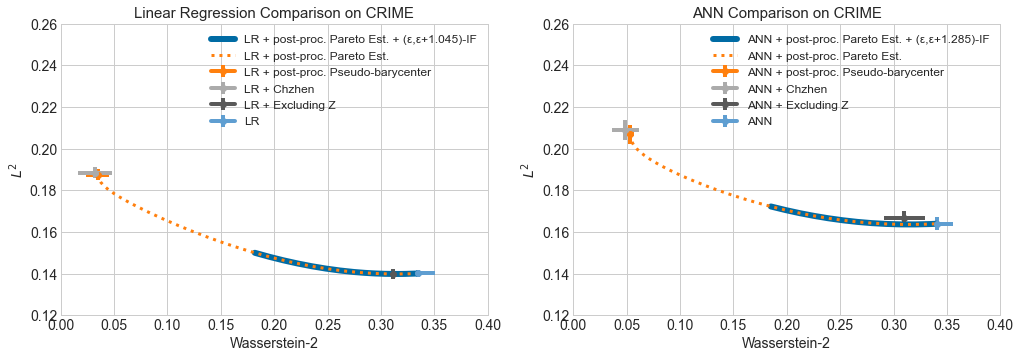

In [37]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style

#axs[0].errorbar(W2_fair_mean, L2_fair_mean, xerr=W2_fair_std, yerr=L2_fair_std, fmt='-o',color = '#006BA4') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_L2_fair_mean, xerr=P_W2_fair_std, yerr=P_L2_fair_std, fmt='-o', color = '#FF800E') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_chzhen_mean, L2_chzhen_mean, xerr=W2_chzhen_std, yerr=L2_chzhen_std, fmt='-o',color = '#ABABAB') # LR + chzhen
axs[0].errorbar(W2_d_mean, L2_d_mean, xerr=W2_d_std, yerr=L2_d_std, fmt='-o', color = '#595959') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, L2_origin_mean, xerr=W2_origin_std, yerr=L2_origin_std, fmt='-o', color = '#5F9ED1') # LR
axs[0].plot(P_X_LR_W2_24,P_Y_LR_W2_24,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + post-proc. Pareto Est. + (\u03B5,\u03B5+1.045)-IF', 'LR + post-proc. Pareto Est.','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
axs[0].set_ylim(0.12, 0.26)
axs[0].set_xlim(0, 0.4)


#axs[1].errorbar(W2_fair_mean_ANN, L2_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=L2_fair_std_ANN, fmt='-o',color = '#006BA4') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_L2_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_L2_fair_std_ANN, fmt='-o', color = '#FF800E') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_chzhen_mean_ANN, L2_chzhen_mean_ANN, xerr=W2_chzhen_std_ANN, yerr=L2_chzhen_std_ANN, fmt='-o',color = '#ABABAB') # ANN + chzhen
axs[1].errorbar(W2_d_mean_ANN, L2_d_mean_ANN, xerr=W2_d_std_ANN, yerr=L2_d_std_ANN, fmt='-o', color = '#595959') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, L2_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=L2_origin_std_ANN, fmt='-o', color = '#5F9ED1') # ANN
axs[1].plot(P_X_ANN_W2_24,P_Y_ANN_W2_24,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + post-proc. Pareto Est. + (\u03B5,\u03B5+1.285)-IF','ANN + post-proc. Pareto Est.','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
axs[1].set_ylim(0.12, 0.26)
axs[1].set_xlim(0, 0.4)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier Compatiblle CRIME L2 vs W2 1', dpi=400,bbox_inches='tight')

<ipython-input-38-892392a4da78>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style


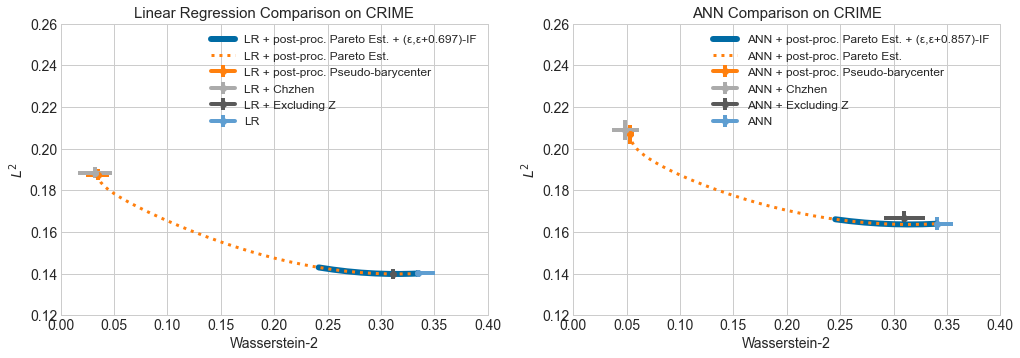

In [38]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style

#axs[0].errorbar(W2_fair_mean, L2_fair_mean, xerr=W2_fair_std, yerr=L2_fair_std, fmt='-o',color = '#006BA4') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_L2_fair_mean, xerr=P_W2_fair_std, yerr=P_L2_fair_std, fmt='-o', color = '#FF800E') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_chzhen_mean, L2_chzhen_mean, xerr=W2_chzhen_std, yerr=L2_chzhen_std, fmt='-o',color = '#ABABAB') # LR + chzhen
axs[0].errorbar(W2_d_mean, L2_d_mean, xerr=W2_d_std, yerr=L2_d_std, fmt='-o', color = '#595959') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, L2_origin_mean, xerr=W2_origin_std, yerr=L2_origin_std, fmt='-o', color = '#5F9ED1') # LR
axs[0].plot(P_X_LR_W2_15,P_Y_LR_W2_15,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + post-proc. Pareto Est. + (\u03B5,\u03B5+0.697)-IF', 'LR + post-proc. Pareto Est.','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
axs[0].set_ylim(0.12, 0.26)
axs[0].set_xlim(0, 0.4)


#axs[1].errorbar(W2_fair_mean_ANN, L2_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=L2_fair_std_ANN, fmt='-o',color = '#006BA4') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_L2_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_L2_fair_std_ANN, fmt='-o', color = '#FF800E') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_chzhen_mean_ANN, L2_chzhen_mean_ANN, xerr=W2_chzhen_std_ANN, yerr=L2_chzhen_std_ANN, fmt='-o',color = '#ABABAB') # ANN + chzhen
axs[1].errorbar(W2_d_mean_ANN, L2_d_mean_ANN, xerr=W2_d_std_ANN, yerr=L2_d_std_ANN, fmt='-o', color = '#595959') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, L2_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=L2_origin_std_ANN, fmt='-o', color = '#5F9ED1') # ANN
axs[1].plot(P_X_ANN_W2_15,P_Y_ANN_W2_15,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + post-proc. Pareto Est. + (\u03B5,\u03B5+0.857)-IF','ANN + post-proc. Pareto Est.','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
axs[1].set_ylim(0.12, 0.26)
axs[1].set_xlim(0, 0.4)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier Compatiblle CRIME L2 vs W2 2', dpi=400,bbox_inches='tight')

<ipython-input-39-b79d796fb55b>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style


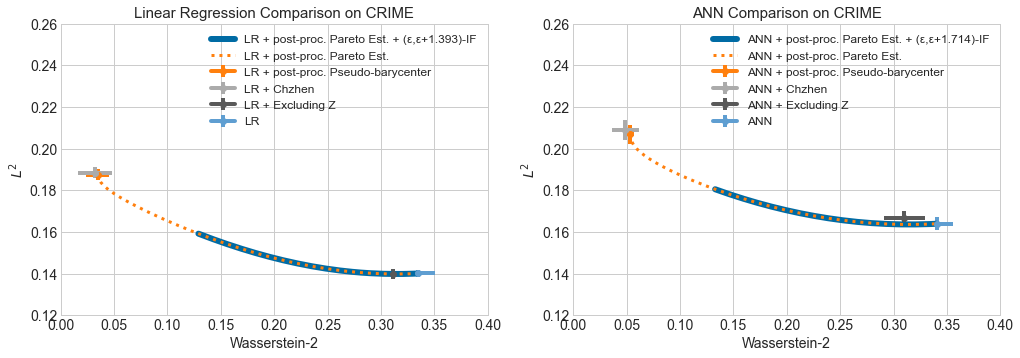

In [39]:
# Generate Figure: L2 vs W2
fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('seaborn-whitegrid') # fivethirtyeight, seaborn-whitegrid is name of style

#axs[0].errorbar(W2_fair_mean, L2_fair_mean, xerr=W2_fair_std, yerr=L2_fair_std, fmt='-o',color = '#006BA4') # LR + pseudo-barycenter data representation
axs[0].errorbar(P_W2_fair_mean, P_L2_fair_mean, xerr=P_W2_fair_std, yerr=P_L2_fair_std, fmt='-o', color = '#FF800E') # LR + post-processing pseudo-barycenter
axs[0].errorbar(W2_chzhen_mean, L2_chzhen_mean, xerr=W2_chzhen_std, yerr=L2_chzhen_std, fmt='-o',color = '#ABABAB') # LR + chzhen
axs[0].errorbar(W2_d_mean, L2_d_mean, xerr=W2_d_std, yerr=L2_d_std, fmt='-o', color = '#595959') # LR + Excluding Z
axs[0].errorbar(W2_origin_mean, L2_origin_mean, xerr=W2_origin_std, yerr=L2_origin_std, fmt='-o', color = '#5F9ED1') # LR
axs[0].plot(P_X_LR_W2_32,P_Y_LR_W2_32,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[0].plot(P_X_LR_W2,P_Y_LR_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR + post-proc. Pareto Est. + (\u03B5,\u03B5+1.393)-IF', 'LR + post-proc. Pareto Est.','LR + post-proc. Pseudo-barycenter','LR + Chzhen','LR + Excluding Z','LR'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[0].set_ylabel('$L^2$', fontsize=14)
axs[0].set_xlabel('Wasserstein-2', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on CRIME", fontsize=15)
axs[0].set_ylim(0.12, 0.26)
axs[0].set_xlim(0, 0.4)


#axs[1].errorbar(W2_fair_mean_ANN, L2_fair_mean_ANN, xerr=W2_fair_std_ANN, yerr=L2_fair_std_ANN, fmt='-o',color = '#006BA4') # ANN + pseudo-barycenter data representation
axs[1].errorbar(P_W2_fair_mean_ANN, P_L2_fair_mean_ANN, xerr=P_W2_fair_std_ANN, yerr=P_L2_fair_std_ANN, fmt='-o', color = '#FF800E') # ANN + post-processing pseudo-barycenter
axs[1].errorbar(W2_chzhen_mean_ANN, L2_chzhen_mean_ANN, xerr=W2_chzhen_std_ANN, yerr=L2_chzhen_std_ANN, fmt='-o',color = '#ABABAB') # ANN + chzhen
axs[1].errorbar(W2_d_mean_ANN, L2_d_mean_ANN, xerr=W2_d_std_ANN, yerr=L2_d_std_ANN, fmt='-o', color = '#595959') # ANN + Dropping D
axs[1].errorbar(W2_origin_mean_ANN, L2_origin_mean_ANN, xerr=W2_origin_std_ANN, yerr=L2_origin_std_ANN, fmt='-o', color = '#5F9ED1') # ANN
axs[1].plot(P_X_ANN_W2_32,P_Y_ANN_W2_32,linewidth = 6, linestyle='solid', color = '#006BA4') # data representation
axs[1].plot(P_X_ANN_W2,P_Y_ANN_W2,linewidth = 3, linestyle='dotted', color = '#FF800E') # post-processing


#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN + post-proc. Pareto Est. + (\u03B5,\u03B5+1.714)-IF','ANN + post-proc. Pareto Est.','ANN + post-proc. Pseudo-barycenter','ANN + Chzhen','ANN + Excluding Z','ANN'], 
           loc='best',fancybox=True, prop={'size': 12})

axs[1].set_ylabel('$L^2$', fontsize=14)
axs[1].set_xlabel('Wasserstein-2', fontsize=14)
axs[1].set_title(f"ANN Comparison on CRIME", fontsize=15)
axs[1].set_ylim(0.12, 0.26)
axs[1].set_xlim(0, 0.4)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier Compatiblle CRIME L2 vs W2 3', dpi=400,bbox_inches='tight')